In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
random.seed(123)

# directory that contains pickle files
undoctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_25_tracking_pkl')
doctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_doctored_25_pkl')

# Helper functions

In [3]:
def data_generator(T, C, le, exclude_labels=[]):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels:
            poses.append(p)
            labels.append(L)
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [5]:
# Load pickle files
Train_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_test_1.pkl"), "rb"))

Train_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_test_1.pkl"), "rb"))


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_undoctored['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


### Optionally Combine doctored and undoctored train/test

In [6]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=32)

X_doctored, Y_doctored = data_generator(Train_doctored,C,le)
X_undoctored, Y_undoctored = data_generator(Train_undoctored,C,le)

# print("Combine doctored and undoctored training sets!")
# X = X_doctored + X_undoctored
# Y = np.concatenate([Y_doctored, Y_undoctored])

X = X_undoctored
Y = Y_undoctored

X_test,Y_test = data_generator(Test_undoctored,C,le)

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

529 (30, 25, 2) (529, 21)
204 (31, 25, 2) (204, 21)


### Cleaning and transforming OpenPose outputs

In [7]:
cleaner = ddnet.OpenPoseDataCleaner(copy=True, filter_joint_idx=ddnet.OP_UPPER_BODY_JOINTS)

In [8]:
# filter points that have too many nans
def filter_many_nan_points(X, Y, nan_thres=0.5):
    """
    Input use 0 to indicate nan
    """
    X_filtered = []
    Y_filtered = []
    for p, y in zip(X, Y):
        if cleaner.count_nan(cleaner.make_nan(p)) / p.size <= nan_thres:
            X_filtered.append(p)
            Y_filtered.append(y)
    Y_filtered = np.array(Y_filtered)
    assert len(X_filtered) == Y_filtered.shape[0]
    return X_filtered, Y_filtered

X_filtered, Y_filtered = filter_many_nan_points(X, Y)
print(len(X_filtered))

# test data
X_test_filtered, Y_test_filtered = filter_many_nan_points(X_test, Y_test)
print(len(X_test_filtered))

529
204


In [9]:
# cleaning and data augmentation
X_clean, Y_clean = cleaner.augment_XY(X_filtered, Y_filtered, factor=5)
X_test_clean, Y_test_clean = cleaner.augment_XY(X_test_filtered, Y_test_filtered, factor=5)

print(len(X_clean), X_clean[0].shape, Y_clean.shape)
print(len(X_test_clean), X_test_clean[0].shape, Y_test_clean.shape)

2645 (30, 10, 2) (2645, 21)
1020 (31, 10, 2) (1020, 21)


In [10]:
# commit changes
X_input, Y_input = X_clean, Y_clean
X_test_input, Y_test_input = X_test_clean, Y_test_clean

### DDNet's preprocess and config

In [11]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_input[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Train, Test 

In [12]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [13]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[:10])

[135 145 145 125 150  85  75 100 195 195 135  90  55 160 135 100  85 165
 145 120 105]
[1.44444444 1.34482759 1.34482759 1.56       1.3        2.29411765
 2.6        1.95       1.         1.         1.44444444 2.16666667
 3.54545455 1.21875    1.44444444 1.95       2.29411765 1.18181818
 1.34482759 1.625      1.85714286]
(2645,)
[2.6 2.6 2.6 2.6 2.6 2.6 2.6 2.6 2.6 2.6]


In [14]:
DD_Net = ddnet.create_DDNet(C)
# DD_Net.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Train and plot loss/accuracy

In [15]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=1000,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


Train on 2645 samples, validate on 1020 samples
Epoch 1/1000
2645/2645 [==============================] - 8s 3ms/step - loss: 9.6108 - accuracy: 0.0461 - val_loss: 6.7064 - val_accuracy: 0.0245
Epoch 2/1000
2645/2645 [==============================] - 0s 78us/step - loss: 9.0622 - accuracy: 0.0726 - val_loss: 6.6783 - val_accuracy: 0.1029
Epoch 3/1000
2645/2645 [==============================] - 0s 76us/step - loss: 8.7120 - accuracy: 0.0926 - val_loss: 6.6472 - val_accuracy: 0.1275
Epoch 4/1000
2645/2645 [==============================] - 0s 78us/step - loss: 8.4741 - accuracy: 0.1047 - val_loss: 6.6144 - val_accuracy: 0.0637
Epoch 5/1000
2645/2645 [==============================] - 0s 

Epoch 53/1000
2645/2645 [==============================] - 0s 72us/step - loss: 2.6620 - accuracy: 0.9433 - val_loss: 4.9209 - val_accuracy: 0.1225
Epoch 54/1000
2645/2645 [==============================] - 0s 71us/step - loss: 2.5962 - accuracy: 0.9527 - val_loss: 4.8963 - val_accuracy: 0.1225
Epoch 55/1000
2645/2645 [==============================] - 0s 71us/step - loss: 2.5351 - accuracy: 0.9539 - val_loss: 4.8738 - val_accuracy: 0.1127
Epoch 56/1000
2645/2645 [==============================] - 0s 72us/step - loss: 2.5038 - accuracy: 0.9520 - val_loss: 4.8531 - val_accuracy: 0.1176
Epoch 57/1000
2645/2645 [==============================] - 0s 72us/step - loss: 2.4337 - accuracy: 0.9603 - val_loss: 4.8306 - val_accuracy: 0.1275
Epoch 58/1000
2645/2645 [==============================] - 0s 72us/step - loss: 2.4061 - accuracy: 0.9629 - val_loss: 4.8044 - val_accuracy: 0.1422
Epoch 59/1000
2645/2645 [==============================] - 0s 73us/step - loss: 2.3359 - accuracy: 0.9709 - val_

Epoch 109/1000
2645/2645 [==============================] - 0s 73us/step - loss: 1.0882 - accuracy: 0.9974 - val_loss: 3.8734 - val_accuracy: 0.1520
Epoch 110/1000
2645/2645 [==============================] - 0s 71us/step - loss: 1.0667 - accuracy: 0.9992 - val_loss: 3.8579 - val_accuracy: 0.1520
Epoch 111/1000
2645/2645 [==============================] - 0s 70us/step - loss: 1.0623 - accuracy: 0.9966 - val_loss: 3.8441 - val_accuracy: 0.1471
Epoch 112/1000
2645/2645 [==============================] - 0s 72us/step - loss: 1.0459 - accuracy: 0.9992 - val_loss: 3.8308 - val_accuracy: 0.1471
Epoch 113/1000
2645/2645 [==============================] - 0s 73us/step - loss: 1.0242 - accuracy: 0.9985 - val_loss: 3.8163 - val_accuracy: 0.1520
Epoch 114/1000
2645/2645 [==============================] - 0s 72us/step - loss: 1.0114 - accuracy: 1.0000 - val_loss: 3.8022 - val_accuracy: 0.1520
Epoch 115/1000
2645/2645 [==============================] - 0s 71us/step - loss: 1.0019 - accuracy: 0.9992

Epoch 164/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.5564 - accuracy: 1.0000 - val_loss: 3.3881 - val_accuracy: 0.1716
Epoch 165/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.5548 - accuracy: 1.0000 - val_loss: 3.3822 - val_accuracy: 0.1765
Epoch 166/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.5437 - accuracy: 1.0000 - val_loss: 3.3771 - val_accuracy: 0.1716
Epoch 167/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.5446 - accuracy: 0.9992 - val_loss: 3.3703 - val_accuracy: 0.1716
Epoch 168/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.5374 - accuracy: 0.9992 - val_loss: 3.3643 - val_accuracy: 0.1667
Epoch 169/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.5273 - accuracy: 1.0000 - val_loss: 3.3583 - val_accuracy: 0.1618
Epoch 170/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.5278 - accuracy: 0.9989

Epoch 219/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.3483 - accuracy: 1.0000 - val_loss: 3.1852 - val_accuracy: 0.1912
Epoch 220/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.3429 - accuracy: 0.9996 - val_loss: 3.1837 - val_accuracy: 0.1912
Epoch 221/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.3475 - accuracy: 1.0000 - val_loss: 3.1822 - val_accuracy: 0.1863
Epoch 222/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.3445 - accuracy: 0.9996 - val_loss: 3.1789 - val_accuracy: 0.1814
Epoch 223/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.3418 - accuracy: 1.0000 - val_loss: 3.1746 - val_accuracy: 0.1814
Epoch 224/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.3415 - accuracy: 1.0000 - val_loss: 3.1696 - val_accuracy: 0.1912
Epoch 225/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.3378 - accuracy: 0.9996

Epoch 274/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2659 - accuracy: 1.0000 - val_loss: 3.0398 - val_accuracy: 0.2500
Epoch 275/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2717 - accuracy: 1.0000 - val_loss: 3.0410 - val_accuracy: 0.2500
Epoch 276/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.2646 - accuracy: 1.0000 - val_loss: 3.0385 - val_accuracy: 0.2500
Epoch 277/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2606 - accuracy: 1.0000 - val_loss: 3.0351 - val_accuracy: 0.2500
Epoch 278/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.2657 - accuracy: 0.9996 - val_loss: 3.0288 - val_accuracy: 0.2500
Epoch 279/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2589 - accuracy: 1.0000 - val_loss: 3.0227 - val_accuracy: 0.2451
Epoch 280/1000
2645/2645 [==============================] - 0s 75us/step - loss: 0.2616 - accuracy: 1.0000

Epoch 329/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2359 - accuracy: 1.0000 - val_loss: 2.8892 - val_accuracy: 0.3088
Epoch 330/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2321 - accuracy: 1.0000 - val_loss: 2.8852 - val_accuracy: 0.3088
Epoch 331/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2338 - accuracy: 0.9996 - val_loss: 2.8820 - val_accuracy: 0.3088
Epoch 332/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2371 - accuracy: 0.9996 - val_loss: 2.8795 - val_accuracy: 0.3088
Epoch 333/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2307 - accuracy: 1.0000 - val_loss: 2.8784 - val_accuracy: 0.3186
Epoch 334/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2371 - accuracy: 1.0000 - val_loss: 2.8789 - val_accuracy: 0.3186
Epoch 335/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2288 - accuracy: 1.0000

Epoch 384/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2206 - accuracy: 1.0000 - val_loss: 2.6762 - val_accuracy: 0.3922
Epoch 385/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 2.6713 - val_accuracy: 0.3922
Epoch 386/1000
2645/2645 [==============================] - 0s 74us/step - loss: 0.2202 - accuracy: 1.0000 - val_loss: 2.6667 - val_accuracy: 0.3922
Epoch 387/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2210 - accuracy: 1.0000 - val_loss: 2.6617 - val_accuracy: 0.3922
Epoch 388/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2173 - accuracy: 1.0000 - val_loss: 2.6566 - val_accuracy: 0.3922
Epoch 389/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2204 - accuracy: 0.9996 - val_loss: 2.6517 - val_accuracy: 0.3971
Epoch 390/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2246 - accuracy: 1.0000

Epoch 439/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2205 - accuracy: 1.0000 - val_loss: 2.3886 - val_accuracy: 0.4412
Epoch 440/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2190 - accuracy: 1.0000 - val_loss: 2.3834 - val_accuracy: 0.4412
Epoch 441/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2209 - accuracy: 1.0000 - val_loss: 2.3781 - val_accuracy: 0.4412
Epoch 442/1000
2645/2645 [==============================] - 0s 69us/step - loss: 0.2206 - accuracy: 1.0000 - val_loss: 2.3728 - val_accuracy: 0.4412
Epoch 443/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2226 - accuracy: 1.0000 - val_loss: 2.3676 - val_accuracy: 0.4461
Epoch 444/1000
2645/2645 [==============================] - 0s 76us/step - loss: 0.2222 - accuracy: 1.0000 - val_loss: 2.3624 - val_accuracy: 0.4461
Epoch 445/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2199 - accuracy: 1.0000

Epoch 494/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2212 - accuracy: 0.9996 - val_loss: 2.1376 - val_accuracy: 0.5000
Epoch 495/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2209 - accuracy: 1.0000 - val_loss: 2.1340 - val_accuracy: 0.5049
Epoch 496/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 2.1306 - val_accuracy: 0.5049
Epoch 497/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.2251 - accuracy: 0.9996 - val_loss: 2.1272 - val_accuracy: 0.5049
Epoch 498/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 2.1238 - val_accuracy: 0.5000
Epoch 499/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 2.1205 - val_accuracy: 0.5000
Epoch 500/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2174 - accuracy: 1.0000

Epoch 549/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2214 - accuracy: 1.0000 - val_loss: 1.9934 - val_accuracy: 0.5294
Epoch 550/1000
2645/2645 [==============================] - 0s 69us/step - loss: 0.2179 - accuracy: 1.0000 - val_loss: 1.9917 - val_accuracy: 0.5294
Epoch 551/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2237 - accuracy: 1.0000 - val_loss: 1.9900 - val_accuracy: 0.5294
Epoch 552/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 1.9883 - val_accuracy: 0.5343
Epoch 553/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 1.9866 - val_accuracy: 0.5343
Epoch 554/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2199 - accuracy: 1.0000 - val_loss: 1.9850 - val_accuracy: 0.5343
Epoch 555/1000
2645/2645 [==============================] - 0s 69us/step - loss: 0.2182 - accuracy: 1.0000

Epoch 604/1000
2645/2645 [==============================] - 0s 69us/step - loss: 0.2178 - accuracy: 1.0000 - val_loss: 1.9391 - val_accuracy: 0.5490
Epoch 605/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2160 - accuracy: 1.0000 - val_loss: 1.9386 - val_accuracy: 0.5490
Epoch 606/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2193 - accuracy: 1.0000 - val_loss: 1.9380 - val_accuracy: 0.5490
Epoch 607/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2227 - accuracy: 1.0000 - val_loss: 1.9374 - val_accuracy: 0.5490
Epoch 608/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2202 - accuracy: 1.0000 - val_loss: 1.9369 - val_accuracy: 0.5490
Epoch 609/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2210 - accuracy: 1.0000 - val_loss: 1.9364 - val_accuracy: 0.5490
Epoch 610/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2151 - accuracy: 0.9996

Epoch 659/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2173 - accuracy: 0.9996 - val_loss: 1.9263 - val_accuracy: 0.5539
Epoch 660/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2178 - accuracy: 1.0000 - val_loss: 1.9262 - val_accuracy: 0.5539
Epoch 661/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2182 - accuracy: 1.0000 - val_loss: 1.9262 - val_accuracy: 0.5539
Epoch 662/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2230 - accuracy: 1.0000 - val_loss: 1.9262 - val_accuracy: 0.5539
Epoch 663/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 1.9262 - val_accuracy: 0.5539
Epoch 664/1000
2645/2645 [==============================] - 0s 77us/step - loss: 0.2183 - accuracy: 1.0000 - val_loss: 1.9263 - val_accuracy: 0.5588
Epoch 665/1000
2645/2645 [==============================] - 0s 73us/step - loss: 0.2200 - accuracy: 1.0000

Epoch 714/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2170 - accuracy: 1.0000 - val_loss: 1.9254 - val_accuracy: 0.5686
Epoch 715/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2163 - accuracy: 1.0000 - val_loss: 1.9258 - val_accuracy: 0.5686
Epoch 716/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2183 - accuracy: 1.0000 - val_loss: 1.9262 - val_accuracy: 0.5686
Epoch 717/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2222 - accuracy: 0.9996 - val_loss: 1.9265 - val_accuracy: 0.5686
Epoch 718/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 1.9269 - val_accuracy: 0.5686
Epoch 719/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 1.9272 - val_accuracy: 0.5686
Epoch 720/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2213 - accuracy: 1.0000

Epoch 769/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2162 - accuracy: 1.0000 - val_loss: 1.9347 - val_accuracy: 0.5686
Epoch 770/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2228 - accuracy: 1.0000 - val_loss: 1.9347 - val_accuracy: 0.5686
Epoch 771/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2204 - accuracy: 0.9996 - val_loss: 1.9348 - val_accuracy: 0.5686
Epoch 772/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 1.9347 - val_accuracy: 0.5686
Epoch 773/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2168 - accuracy: 1.0000 - val_loss: 1.9345 - val_accuracy: 0.5686
Epoch 774/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2216 - accuracy: 1.0000 - val_loss: 1.9343 - val_accuracy: 0.5686
Epoch 775/1000
2645/2645 [==============================] - 0s 76us/step - loss: 0.2201 - accuracy: 1.0000

Epoch 824/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2154 - accuracy: 0.9996 - val_loss: 1.9418 - val_accuracy: 0.5686
Epoch 825/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2198 - accuracy: 1.0000 - val_loss: 1.9421 - val_accuracy: 0.5686
Epoch 826/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2176 - accuracy: 1.0000 - val_loss: 1.9424 - val_accuracy: 0.5686
Epoch 827/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2213 - accuracy: 1.0000 - val_loss: 1.9426 - val_accuracy: 0.5686
Epoch 828/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2176 - accuracy: 1.0000 - val_loss: 1.9428 - val_accuracy: 0.5686
Epoch 829/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2187 - accuracy: 1.0000 - val_loss: 1.9431 - val_accuracy: 0.5686
Epoch 830/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2175 - accuracy: 1.0000

Epoch 879/1000
2645/2645 [==============================] - 0s 80us/step - loss: 0.2167 - accuracy: 1.0000 - val_loss: 1.9421 - val_accuracy: 0.5686
Epoch 880/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2178 - accuracy: 1.0000 - val_loss: 1.9419 - val_accuracy: 0.5686
Epoch 881/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2143 - accuracy: 1.0000 - val_loss: 1.9416 - val_accuracy: 0.5686
Epoch 882/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2191 - accuracy: 1.0000 - val_loss: 1.9414 - val_accuracy: 0.5686
Epoch 883/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2184 - accuracy: 1.0000 - val_loss: 1.9413 - val_accuracy: 0.5686
Epoch 884/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2205 - accuracy: 1.0000 - val_loss: 1.9413 - val_accuracy: 0.5686
Epoch 885/1000
2645/2645 [==============================] - 0s 76us/step - loss: 0.2153 - accuracy: 1.0000

Epoch 934/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2165 - accuracy: 0.9996 - val_loss: 1.9437 - val_accuracy: 0.5735
Epoch 935/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2203 - accuracy: 0.9996 - val_loss: 1.9437 - val_accuracy: 0.5735
Epoch 936/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2192 - accuracy: 1.0000 - val_loss: 1.9437 - val_accuracy: 0.5735
Epoch 937/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2170 - accuracy: 1.0000 - val_loss: 1.9436 - val_accuracy: 0.5735
Epoch 938/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2197 - accuracy: 1.0000 - val_loss: 1.9436 - val_accuracy: 0.5735
Epoch 939/1000
2645/2645 [==============================] - 0s 70us/step - loss: 0.2210 - accuracy: 1.0000 - val_loss: 1.9437 - val_accuracy: 0.5735
Epoch 940/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2169 - accuracy: 1.0000

Epoch 989/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2149 - accuracy: 1.0000 - val_loss: 1.9450 - val_accuracy: 0.5735
Epoch 990/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2143 - accuracy: 1.0000 - val_loss: 1.9449 - val_accuracy: 0.5735
Epoch 991/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2193 - accuracy: 1.0000 - val_loss: 1.9448 - val_accuracy: 0.5735
Epoch 992/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2216 - accuracy: 0.9992 - val_loss: 1.9446 - val_accuracy: 0.5735
Epoch 993/1000
2645/2645 [==============================] - 0s 76us/step - loss: 0.2193 - accuracy: 0.9996 - val_loss: 1.9445 - val_accuracy: 0.5735
Epoch 994/1000
2645/2645 [==============================] - 0s 72us/step - loss: 0.2144 - accuracy: 1.0000 - val_loss: 1.9444 - val_accuracy: 0.5735
Epoch 995/1000
2645/2645 [==============================] - 0s 71us/step - loss: 0.2189 - accuracy: 1.0000

Epoch 45/400
2645/2645 [==============================] - 0s 73us/step - loss: 0.2153 - accuracy: 1.0000 - val_loss: 1.9478 - val_accuracy: 0.5735
Epoch 46/400
2645/2645 [==============================] - 0s 71us/step - loss: 0.2160 - accuracy: 1.0000 - val_loss: 1.9481 - val_accuracy: 0.5735
Epoch 47/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2143 - accuracy: 1.0000 - val_loss: 1.9484 - val_accuracy: 0.5735
Epoch 48/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2149 - accuracy: 1.0000 - val_loss: 1.9485 - val_accuracy: 0.5735
Epoch 49/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 1.9485 - val_accuracy: 0.5735
Epoch 50/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2158 - accuracy: 1.0000 - val_loss: 1.9484 - val_accuracy: 0.5735
Epoch 51/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2152 - accuracy: 1.0000 - val_loss: 1

Epoch 101/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2138 - accuracy: 1.0000 - val_loss: 1.9475 - val_accuracy: 0.5735
Epoch 102/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2122 - accuracy: 0.9996 - val_loss: 1.9474 - val_accuracy: 0.5735
Epoch 103/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.9473 - val_accuracy: 0.5735
Epoch 104/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2154 - accuracy: 1.0000 - val_loss: 1.9472 - val_accuracy: 0.5735
Epoch 105/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2178 - accuracy: 1.0000 - val_loss: 1.9471 - val_accuracy: 0.5735
Epoch 106/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2166 - accuracy: 1.0000 - val_loss: 1.9469 - val_accuracy: 0.5735
Epoch 107/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2155 - accuracy: 1.0000 - val_

Epoch 157/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2163 - accuracy: 1.0000 - val_loss: 1.9460 - val_accuracy: 0.5784
Epoch 158/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2155 - accuracy: 1.0000 - val_loss: 1.9461 - val_accuracy: 0.5784
Epoch 159/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2160 - accuracy: 1.0000 - val_loss: 1.9464 - val_accuracy: 0.5784
Epoch 160/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2139 - accuracy: 1.0000 - val_loss: 1.9466 - val_accuracy: 0.5784
Epoch 161/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2130 - accuracy: 1.0000 - val_loss: 1.9467 - val_accuracy: 0.5784
Epoch 162/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2142 - accuracy: 1.0000 - val_loss: 1.9469 - val_accuracy: 0.5784
Epoch 163/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2097 - accuracy: 1.0000 - val_

Epoch 213/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2138 - accuracy: 1.0000 - val_loss: 1.9499 - val_accuracy: 0.5735
Epoch 214/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2066 - accuracy: 1.0000 - val_loss: 1.9496 - val_accuracy: 0.5735
Epoch 215/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2142 - accuracy: 1.0000 - val_loss: 1.9493 - val_accuracy: 0.5784
Epoch 216/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2164 - accuracy: 0.9996 - val_loss: 1.9489 - val_accuracy: 0.5784
Epoch 217/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2129 - accuracy: 1.0000 - val_loss: 1.9485 - val_accuracy: 0.5784
Epoch 218/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2146 - accuracy: 1.0000 - val_loss: 1.9482 - val_accuracy: 0.5784
Epoch 219/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2118 - accuracy: 1.0000 - val_

Epoch 269/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2088 - accuracy: 1.0000 - val_loss: 1.9440 - val_accuracy: 0.5784
Epoch 270/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2142 - accuracy: 1.0000 - val_loss: 1.9438 - val_accuracy: 0.5784
Epoch 271/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2161 - accuracy: 1.0000 - val_loss: 1.9437 - val_accuracy: 0.5784
Epoch 272/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2131 - accuracy: 1.0000 - val_loss: 1.9436 - val_accuracy: 0.5784
Epoch 273/400
2645/2645 [==============================] - 0s 72us/step - loss: 0.2107 - accuracy: 1.0000 - val_loss: 1.9436 - val_accuracy: 0.5784
Epoch 274/400
2645/2645 [==============================] - 0s 72us/step - loss: 0.2232 - accuracy: 0.9989 - val_loss: 1.9434 - val_accuracy: 0.5735
Epoch 275/400
2645/2645 [==============================] - 0s 71us/step - loss: 0.2150 - accuracy: 0.9992 - val_

Epoch 325/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2117 - accuracy: 0.9996 - val_loss: 1.9404 - val_accuracy: 0.5784
Epoch 326/400
2645/2645 [==============================] - 0s 66us/step - loss: 0.2109 - accuracy: 1.0000 - val_loss: 1.9405 - val_accuracy: 0.5784
Epoch 327/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2110 - accuracy: 1.0000 - val_loss: 1.9405 - val_accuracy: 0.5784
Epoch 328/400
2645/2645 [==============================] - 0s 68us/step - loss: 0.2119 - accuracy: 0.9996 - val_loss: 1.9406 - val_accuracy: 0.5784
Epoch 329/400
2645/2645 [==============================] - 0s 75us/step - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.9407 - val_accuracy: 0.5784
Epoch 330/400
2645/2645 [==============================] - 0s 73us/step - loss: 0.2144 - accuracy: 1.0000 - val_loss: 1.9408 - val_accuracy: 0.5784
Epoch 331/400
2645/2645 [==============================] - 0s 73us/step - loss: 0.2121 - accuracy: 1.0000 - val_

Epoch 381/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2129 - accuracy: 1.0000 - val_loss: 1.9401 - val_accuracy: 0.5735
Epoch 382/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2119 - accuracy: 1.0000 - val_loss: 1.9403 - val_accuracy: 0.5735
Epoch 383/400
2645/2645 [==============================] - 0s 69us/step - loss: 0.2110 - accuracy: 1.0000 - val_loss: 1.9404 - val_accuracy: 0.5735
Epoch 384/400
2645/2645 [==============================] - 0s 70us/step - loss: 0.2080 - accuracy: 1.0000 - val_loss: 1.9406 - val_accuracy: 0.5735
Epoch 385/400
2645/2645 [==============================] - 0s 71us/step - loss: 0.2145 - accuracy: 1.0000 - val_loss: 1.9407 - val_accuracy: 0.5735
Epoch 386/400
2645/2645 [==============================] - 0s 71us/step - loss: 0.2147 - accuracy: 1.0000 - val_loss: 1.9407 - val_accuracy: 0.5735
Epoch 387/400
2645/2645 [==============================] - 0s 75us/step - loss: 0.2107 - accuracy: 0.9996 - val_

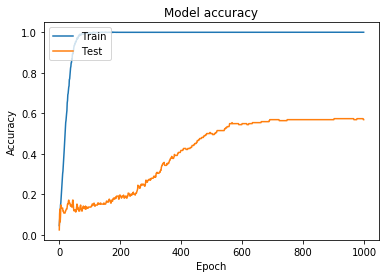

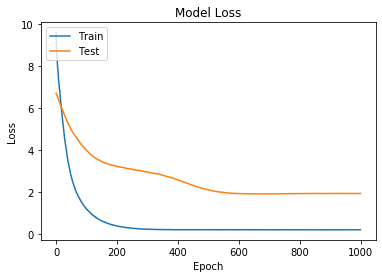

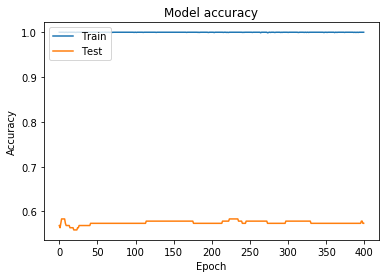

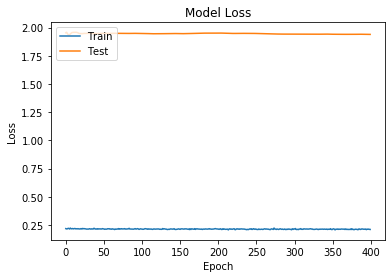

In [16]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [17]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

[[10  0 10  0  0  5  0  0  0 10  0  0  0  0  0  0  0  0  5  0  5]
 [ 0  5  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  5  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0 10 25  5  0  0  0  0  0  0  0  0 10  0  0  5  0]
 [ 0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0 10  0  0  0  0  0  5  5  0  0  0  0]
 [ 0  0  0  0  0 15  0  5  0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  5  0  0  0  0  0 35  0  0  0  5  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  5  5  0  0  0  0  0 15]
 [ 0  0  0  0  0  0  0  5  0 55 15  0  0  0  0  0  0  0  0  0  5]
 [ 0  5  0  0  0  5  5  0  0  0 15  0  0  5  5 10  0  0  0 10  0]
 [ 0  0  0  5  0  0  0  0  0  0  5 15  0  0  0  0  0  0  5  5  0]
 [ 0 10  0  0  0  0  0  0  0  5  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0  0 65  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0 10  0  0  5 45  0  0  0  0  0  5]
 [ 0  0  0

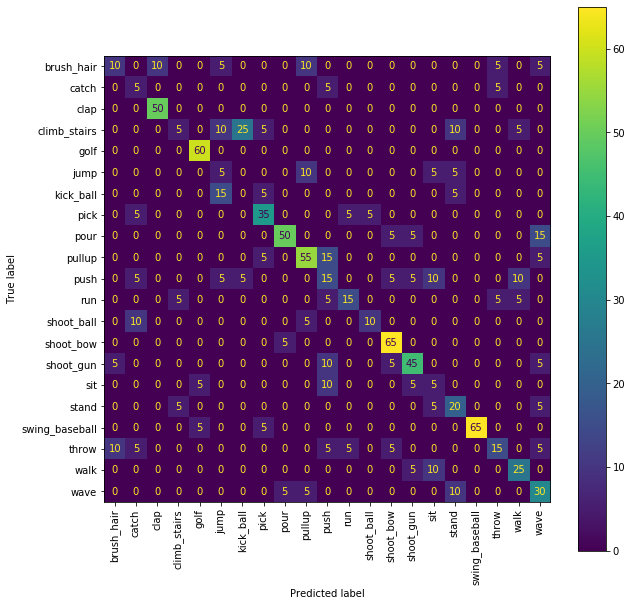

In [18]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)

### Save model to disk

In [19]:
model_path = 'jhmdb_openpose_model_upper_10.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Refit using Training + Test Data

In [ ]:
print(Y_input.shape, Y_test_input.shape)
X_refit = X_input + X_test_input
Y_refit = np.concatenate([Y_input, Y_test_input])
assert len(X_refit) == Y_refit.shape[0]
print(len(X_refit))
refit_sample_weight = get_sample_weight(Y_refit)

In [ ]:
X_refit_0, X_refit_1 = ddnet.preprocess_batch(X_refit, C)

In [ ]:
# create a new net
refit_net = ddnet.create_DDNet(C)

lr = 1e-3
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )

lr = 1e-4
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )


In [ ]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [ ]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10_refit.h5'
ddnet.save_DDNet(refit_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)